In [3]:
################## Simulated Annealing driven by the Free-Energy: The SAFE Algorithm ######################
########## Arnab Barua, Haralampos Hatzikirou #########################


In [4]:
## Define the libraries which will be used for the optimization processes
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
## Define the  joint entropy of multivariate data

def joint_entropy(data):
    """
    Calculate the joint entropy of multivariate data.

    Parameters:
    - data: 1D or 2D array where each row is a sample and each column is a feature.

    Returns:
    - Joint entropy value.
    """
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    if data.ndim == 1:
        data = data.reshape(-1, 1)  # Reshape 1D array to 2D array with one column
    assert data.ndim == 2, "Data must be a 1D or 2D array or DataFrame."

    # Calculate joint probability distribution
    _, counts = np.unique(data, axis=0, return_counts=True)
    probs = counts / len(data)

    # Calculate joint entropy
    joint_entropy = -np.sum(probs * np.log(probs ))  # Adding small epsilon to avoid log(0)

    return joint_entropy


In [6]:
## The SAFE algorithm: Simulated Anealing driven by Free-Energy

def simulated_annealing(objective_function_energy, objective_function_entropy, initial_solution, perturbation_range=1, beta=2, min_length=2, initial_temperature=1000.0, cooling_rate=0.99, min_temperature=0.00, max_iterations=10000, eta=0.01, epsilon=1e-8, alpha=0.1):
    current_solution = initial_solution
    best_solution = current_solution
    current_energy = objective_function_energy(current_solution)
    current_entropy = objective_function_entropy(current_solution)  # Initialize with entropy of initial solution
    best_energy = current_energy
    best_entropy = current_entropy
    temperature = initial_temperature

    energy_history = [current_energy]
    entropy_history = [current_entropy]
    beta_history = [beta]
    cost_history = [current_energy - temperature * current_entropy]
    solution_length_history = [len(current_solution)]

    cumulative_gradient = 0

    for iteration in range(max_iterations):
        # Apply perturbation to the current solution
        perturbation = np.random.uniform(-perturbation_range, perturbation_range, current_solution.shape)
        perturbed_solution = current_solution + perturbation

        # Randomly select a subset of the perturbed solution with a minimum length
        subset_size = np.random.randint(min_length, len(perturbed_solution) + 1)
        subset_indices = np.random.choice(len(perturbed_solution), size=subset_size, replace=False)
        subset_solution = perturbed_solution[subset_indices]

        # Evaluate the objective functions for the subset
        new_energy = objective_function_energy(subset_solution)
        new_entropy = objective_function_entropy(subset_solution)  # Update with entropy of current subset

        # Calculate the differences
        energy_diff = new_energy - current_energy
        entropy_diff = new_entropy - current_entropy

        # Calculate weighted differences
        free_energy_diff = energy_diff - 1* entropy_diff

        if free_energy_diff <= 0 or np.random.uniform(0,1)<= np.exp(-(1/temperature)*free_energy_diff):
            current_solution = subset_solution
            current_energy = new_energy
            best_solution = subset_solution
            best_energy = new_energy
            best_entropy = new_entropy
            current_entropy = new_entropy
        # Update current entropy to be the entropy of the current subset solution
       
        # Compute the gradient of the entropy change
        gradient = free_energy_diff ** 2

        current_cost = gradient

        # Keep track of the energy, entropy, beta, cost, and solution length
        energy_history.append(current_energy)
        entropy_history.append(current_entropy)
        beta_history.append(beta)
        cost_history.append(gradient)
        solution_length_history.append(len(current_solution))

        # Reduce temperature
        temperature *= cooling_rate
        # ;(0.5**5)/(0.5**5+temperature**5)
        #temperature += -2*1*temperature**(-3)
        if (temperature < min_temperature ) and current_cost <= 0.01:
            break

    return best_solution, best_energy, best_entropy, energy_history, entropy_history, beta_history, cost_history, solution_length_history


In [7]:
def standard_simulated_annealing(objective_function, initial_solution, perturbation_range=1, initial_temperature=1000.0, cooling_rate=0.99, min_temperature=0.000, max_iterations=10000):
    current_solution = initial_solution
    best_solution = current_solution
    current_energy = objective_function(current_solution)
    best_energy = current_energy
    temperature = initial_temperature
    energy_history = [current_energy]
    cost_history_2 = [(abs(current_energy - best_energy))**2]  # Initialize cost history with initial cost
    solution_length_history_ssa = [len(current_solution)]
    for iteration in range(max_iterations):
        # Apply perturbation to the current solution
        perturbation = np.random.uniform(-perturbation_range, perturbation_range, current_solution.shape)
        perturbed_solution = current_solution + perturbation

        # Randomly select a subset of the perturbed solution
        subset_size = np.random.randint(2, len(perturbed_solution) + 1)
        subset_indices = np.random.choice(len(perturbed_solution), size=subset_size, replace=False)
        #subset_solution = perturbed_solution[subset_indices]
        subset_solution=perturbed_solution
        # Evaluate the objective function for the perturbed solution
        new_energy = objective_function(subset_solution)

        # Determine whether to accept the new solution based on energy comparison
        if new_energy <= current_energy or np.random.rand() <= np.exp((current_energy - new_energy) / temperature):
            current_solution = perturbed_solution
            current_energy = new_energy
            # Update the best solution if necessary
            if new_energy < best_energy:
                best_solution = subset_solution
                best_energy = new_energy

        # Update cost history with the squared difference of current_energy and best_energy
        cost_history_2.append((current_energy - best_energy)**2)

        # Reduce temperature
        temperature *= cooling_rate
        if temperature < min_temperature:
            break

        # Keep track of the energy history
        energy_history.append(current_energy)
        solution_length_history_ssa.append(len(current_solution))
    return best_solution, best_energy, energy_history, cost_history_2,solution_length_history_ssa

In [13]:
def plot_simulation_results(energy_histories_sa, energy_histories_ssa, entropy_histories_sa, cost_history_2, cost_histories_sa, solution_length_histories_sa,solution_length_histories_ssa, num_simulations):
    # Convert lists to arrays for easier manipulation
    energy_histories_sa = np.array(energy_histories_sa)
    energy_histories_ssa = np.array(energy_histories_ssa)
    entropy_histories_sa = np.array(entropy_histories_sa)
    cost_histories_sa = np.array(cost_histories_sa)
    cost_history_2 = np.array(cost_history_2)
    solution_length_histories_sa = np.array(solution_length_histories_sa)
    solution_length_histories_ssa = np.array(solution_length_histories_ssa)
    # Compute mean and standard deviation across simulations for SA
    mean_energy_sa = np.mean(energy_histories_sa, axis=0)
    std_energy_sa = np.std(energy_histories_sa, axis=0)
    mean_entropy_sa = np.mean(entropy_histories_sa, axis=0)
    std_entropy_sa = np.std(entropy_histories_sa, axis=0)
    mean_cost_sa = np.mean(cost_histories_sa, axis=0)
    std_cost_sa = np.std(cost_histories_sa, axis=0)
    mean_solution_length_sa = np.mean(solution_length_histories_sa, axis=0)
    std_solution_length_sa = np.std(solution_length_histories_sa, axis=0)
    mean_solution_length_ssa = np.mean(solution_length_histories_ssa, axis=0)
    std_solution_length_ssa = np.std(solution_length_histories_ssa, axis=0)
    # Compute mean across simulations for SSA
    mean_energy_ssa = np.mean(energy_histories_ssa, axis=0)
    std_energy_ssa = np.std(energy_histories_ssa, axis=0)
    mean_cost_sa_2 = np.mean(cost_history_2, axis=0)
    std_cost_sa_2 = np.std(cost_history_2, axis=0)

    # Plotting the results
    plt.figure(figsize=(18, 6))

    # Energy plot for Simulated Annealing and Standard Simulated Annealing
    plt.subplot(2, 2, 1)
    plt.loglog(mean_energy_sa, color='blue', lw=5, label='Free-energy driven SA')
    plt.fill_between(np.arange(len(mean_energy_sa)), mean_energy_sa - std_energy_sa / np.sqrt(num_simulations), mean_energy_sa + std_energy_sa / np.sqrt(num_simulations), color='blue', alpha=0.2)
    plt.loglog(mean_energy_ssa, color='red', lw=5, label='Standard SA')
    plt.fill_between(np.arange(len(mean_energy_ssa)), mean_energy_ssa - std_energy_ssa/ np.sqrt(num_simulations), mean_energy_ssa + std_energy_ssa/ np.sqrt(num_simulations), color='red', alpha=0.2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Iteration (n)', fontsize=15)
    plt.ylabel('Energy (E(n))', fontsize=15)
    plt.legend(fontsize=10,frameon=False)

    # Entropy plot for Simulated Annealing
    plt.subplot(2, 2, 2)
    plt.loglog(mean_entropy_sa, color='blue', lw=5, label='Free-energy driven SA')
    plt.fill_between(np.arange(len(mean_entropy_sa)), mean_entropy_sa - std_entropy_sa / np.sqrt(num_simulations), mean_entropy_sa + std_entropy_sa / np.sqrt(num_simulations), color='blue', alpha=0.2)
    plt.xlabel('Iteration (n)', fontsize=15)
    plt.ylabel('Entropy (S(n))', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=10,frameon=False)
    # Solution length plot for Simulated Annealing
    plt.subplot(2, 2, 3)
    plt.loglog(mean_solution_length_sa, color='blue', lw=5, label='Free-energy driven SA')
    plt.fill_between(np.arange(len(mean_solution_length_sa)), mean_solution_length_sa - std_solution_length_sa / np.sqrt(num_simulations), mean_solution_length_sa + std_solution_length_sa / np.sqrt(num_simulations), color='blue', alpha=0.2)
    plt.loglog(mean_solution_length_ssa, color='red', lw=5, label='Standard SA')
    plt.fill_between(np.arange(len(mean_solution_length_ssa)), mean_solution_length_ssa - std_solution_length_ssa / np.sqrt(num_simulations), mean_solution_length_ssa + std_solution_length_ssa / np.sqrt(num_simulations), color='blue', alpha=0.2)
    plt.xlabel('Iteration (n)', fontsize=15)
    plt.ylabel('Solution length (l(n))', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=10,frameon=False)
    # Cost plot for Simulated Annealing
    plt.subplot(2, 2, 4)
    plt.loglog(mean_cost_sa, color='blue', lw=5, label='Free-energy driven SA')
    plt.fill_between(np.arange(len(mean_cost_sa)), mean_cost_sa - std_cost_sa / np.sqrt(num_simulations), mean_cost_sa + std_cost_sa / np.sqrt(num_simulations), color='blue', alpha=0.2)
    #plt.loglog(mean_cost_sa_2, color='blue', lw=5, label='Standard SA')
    #plt.fill_between(np.arange(len(mean_cost_sa_2)), mean_cost_sa_2 - std_cost_sa_2 / np.sqrt(num_simulations), mean_cost_sa_2 + std_cost_sa_2 / np.sqrt(num_simulations), color='blue', alpha=0.2)
    plt.xlabel('Iteration (n)', fontsize=15)
    plt.ylabel('F(n)', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=10,frameon=False)

    plt.tight_layout()
    plt.show()


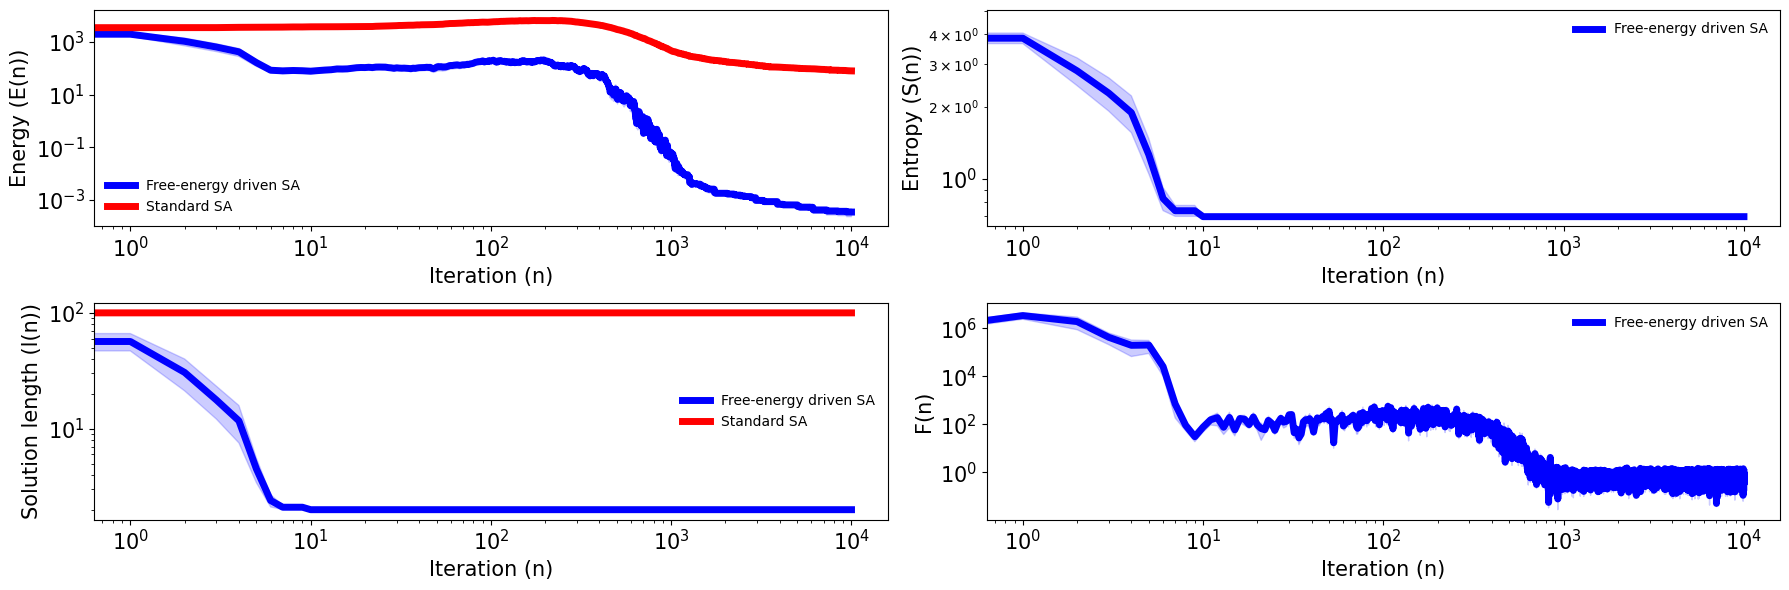

Final Solutions:
Simulated Annealing (SA):
Iteration 1: [-0.01473013  0.00369288]
Iteration 2: [-0.01016246 -0.01727918]
Iteration 3: [-1.23739117e-02 -7.14361448e-05]
Iteration 4: [-0.00672771  0.0246387 ]
Iteration 5: [ 0.01133452 -0.00642137]
Iteration 6: [ 0.00698591 -0.00772691]
Iteration 7: [ 0.0035538  -0.00811296]
Iteration 8: [-0.00877443  0.00321356]
Iteration 9: [ 0.0289895  -0.01372654]
Iteration 10: [-0.00046162  0.00050737]


In [15]:
# Example usage
if __name__ == "__main__":
    # Define objective functions
    def objective_function_energy(solution):
        return 0.01 * len(solution) + np.sum(solution ** 2 - 0.01 * np.cos(2 * np.pi * solution))
        #return np.sum((solution-5)**2)

    def objective_function_entropy(solution):
        return joint_entropy(solution)

    # Set parameters
    num_simulations = 10
    initial_solution = np.random.uniform(-10, 10, size=(100,))

    energy_histories_sa = []
    entropy_histories_sa = []
    cost_histories_sa = []
    energy_histories_ssa = []
    cost_history_2 = []
    solution_length_histories_sa = []
    final_solutions_sa = []
    solution_length_histories_ssa = []
    # Run simulations
    for _ in range(num_simulations):
        best_solution_sa, _, _, energy_history_sa, entropy_history_sa, _, cost_history_sa, solution_length_history_sa = simulated_annealing(objective_function_energy, objective_function_entropy, initial_solution)
        _, _, energy_history_ssa, cost_history_sa_2,solution_length_history_ssa  = standard_simulated_annealing(objective_function_energy, initial_solution)
        final_solutions_sa.append(best_solution_sa)
        energy_histories_sa.append(energy_history_sa)
        entropy_histories_sa.append(entropy_history_sa)
        cost_histories_sa.append(cost_history_sa)
        energy_histories_ssa.append(energy_history_ssa)
        cost_history_2.append(cost_history_sa_2)
        solution_length_histories_sa.append(solution_length_history_sa)
        solution_length_histories_ssa.append(solution_length_history_ssa)
    # Plot results
    plot_simulation_results(energy_histories_sa, energy_histories_ssa, entropy_histories_sa, cost_history_2, cost_histories_sa, solution_length_histories_sa,solution_length_histories_ssa, num_simulations)
     # Print final solutions
   # Print final solutions
    print("Final Solutions:")
    print("Simulated Annealing (SA):")
    for i, solution_sa in enumerate(final_solutions_sa):
        print(f"Iteration {i+1}: {solution_sa}")

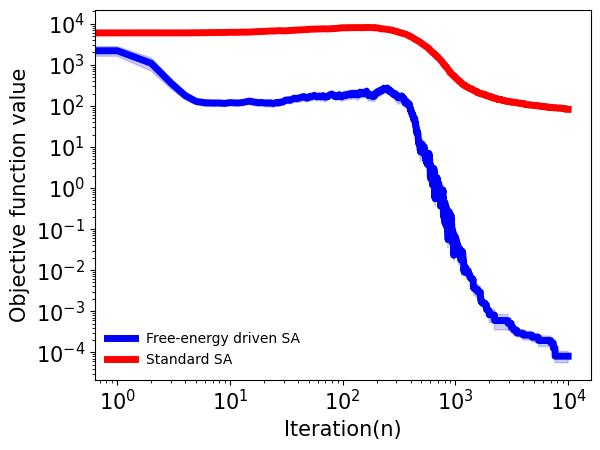

In [12]:
energy_histories_sa = np.array(energy_histories_sa)
energy_histories_ssa = np.array(energy_histories_ssa)


    # Compute mean and standard deviation across simulations for SA
mean_energy_sa = np.mean(energy_histories_sa, axis=0)
std_energy_sa = np.std(energy_histories_sa, axis=0)
   
    # Compute mean across simulations for SSA
mean_energy_ssa = np.mean(energy_histories_ssa, axis=0)
std_energy_ssa = np.std(energy_histories_ssa, axis=0)

plt.subplot(1,1, 1)
plt.loglog(mean_energy_sa, color='blue', lw=5, label='Free-energy driven SA')
plt.fill_between(np.arange(len(mean_energy_sa)), mean_energy_sa - std_energy_sa / np.sqrt(num_simulations), mean_energy_sa + std_energy_sa / np.sqrt(num_simulations), color='blue', alpha=0.2)
plt.loglog(mean_energy_ssa, color='red', lw=5, label='Standard SA')
plt.fill_between(np.arange(len(mean_energy_ssa)), mean_energy_ssa - std_energy_ssa/ np.sqrt(num_simulations), mean_energy_ssa + std_energy_ssa/ np.sqrt(num_simulations), color='red', alpha=0.2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Iteration(n)', fontsize=15)
plt.ylabel('Objective function value', fontsize=15)
plt.legend(fontsize=10,frameon=False)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Generate random data
np.random.seed(42)
time = np.linspace(0, 10, 100)  # Time vector
true_k = np.array([1.5, 2.0, 1.0])  # True value of k (three-dimensional)
x_true = np.exp(-true_k[:, None] * time)  # True solution of the ODE
noise = np.random.normal(0, 0.1, size=x_true.shape)  # Add some noise
x_noisy = x_true + noise  # Noisy data


In [6]:
# Define the objective functions for energy and entropy
def objective_function_energy(k):
    energy = np.sum((true_k - k)**2)
    return energy

def objective_function_entropy(k):
    return joint_entropy(k)


In [7]:
# Simulated Annealing function
def simulated_annealing(objective_function_energy, objective_function_entropy, initial_solution, perturbation_range=1, beta=2, min_length=3, initial_temperature=1000.0, cooling_rate=0.99, min_temperature=0.00, max_iterations=10000, eta=0.01, epsilon=1e-8, alpha=0.1):
    current_solution = initial_solution
    best_solution = current_solution
    current_energy = objective_function_energy(current_solution)
    current_entropy = objective_function_entropy(current_solution)
    best_energy = current_energy
    best_entropy = current_entropy
    temperature = initial_temperature

    energy_history = [current_energy]
    entropy_history = [current_entropy]
    beta_history = [beta]
    cost_history = [current_energy - current_entropy]
    solution_length_history = [len(current_solution)]
    mean_k_history = [current_solution.mean(axis=0)]

    cumulative_gradient = 0

    for iteration in range(max_iterations):
        perturbation = np.random.uniform(-perturbation_range, perturbation_range, current_solution.shape)
        perturbed_solution = current_solution + perturbation

        subset_size = np.random.randint(min_length, len(perturbed_solution) + 1)
        subset_indices = np.random.choice(len(perturbed_solution), size=subset_size, replace=False)
        subset_solution = perturbed_solution[subset_indices]

        new_energy = objective_function_energy(subset_solution)
        new_entropy = objective_function_entropy(subset_solution)

        energy_diff = new_energy - current_energy
        entropy_diff = new_entropy - current_entropy

        free_energy_diff = energy_diff - 1 * entropy_diff

        if free_energy_diff <= 0 or np.random.uniform(0, 1) <= np.exp(-(1 / temperature) * free_energy_diff):
            current_solution = subset_solution
            current_energy = new_energy
            best_solution = subset_solution
            best_energy = new_energy
            best_entropy = new_entropy
            current_entropy = new_entropy

        gradient = free_energy_diff ** 2

        current_cost = gradient

        energy_history.append(current_energy)
        entropy_history.append(current_entropy)
        beta_history.append(beta)
        cost_history.append(gradient)
        solution_length_history.append(len(current_solution))
        mean_k_history.append(current_solution.mean(axis=0))

        temperature *= cooling_rate

        if temperature < min_temperature and current_cost <= 0.01:
            break

    return best_solution, best_energy, best_entropy, energy_history, entropy_history, beta_history, cost_history, solution_length_history, mean_k_history


In [9]:
#  Initial solution
initial_solution = np.random.uniform(-10, 10, size=(100, 3))  # Initial guess for k (three-dimensional)

# Store results of multiple runs
all_best_solutions = []
all_best_energies = []
all_best_entropies = []
all_energy_histories = []
all_entropy_histories = []
all_beta_histories = []
all_cost_histories = []
all_solution_length_histories = []
all_mean_k_histories = []

# Run the simulated annealing 10 times
num_runs = 10
for i in range(num_runs):
    best_solution, best_energy, best_entropy, energy_history, entropy_history, beta_history, cost_history, solution_length_history, mean_k_history = simulated_annealing(
        objective_function_energy,
        objective_function_entropy,
        initial_solution
    )
    
    all_best_solutions.append(best_solution)
    print(all_best_solutions)
    all_best_energies.append(best_energy)
    all_best_entropies.append(best_entropy)
    all_energy_histories.append(energy_history)
    all_entropy_histories.append(entropy_history)
    all_beta_histories.append(beta_history)
    all_cost_histories.append(cost_history)
    all_solution_length_histories.append(solution_length_history)
    all_mean_k_histories.append(mean_k_history)

    print(f"Run {i+1}")
    print(f"Estimated k (average): {best_solution.mean(axis=0)}")
    print(f"Best energy: {best_energy}")
    print(f"Best entropy: {best_entropy}\n")

NameError: name 'objective_function_energy' is not defined

In [ ]:
plt.figure(figsize=(18, 12))
# Plot 1: Noisy data and fitted model
plt.subplot(2, 2, 1)
for i in range(3):
    plt.plot(time, x_noisy[i], 'o', label=f'Noisy data (component {i+1})')
    mean_k = all_best_solutions[-1].mean(axis=0)[i]
    std_k =all_best_solutions[-1].std(axis=0)[i]
    plt.plot(time, np.exp(-mean_k * time), 'o-', lw=3, label=rf'Fitted model (component {i+1}, $\alpha_{i+1}$={mean_k:.4f} ± {std_k:.4f})')
    plt.fill_between(time, np.exp(-(mean_k + std_k/np.sqrt(num_runs)) * time), np.exp(-(mean_k - std_k/np.sqrt(num_runs)) * time), color='gray', alpha=0.2)
plt.xlabel('Time (t)', fontsize=15)
plt.ylabel('x(t)', fontsize=15)
plt.legend(frameon=False, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot 2: Energy history
plt.subplot(2, 2, 2)
energy_mean = np.mean(all_energy_histories, axis=0)
energy_std = np.std(all_energy_histories, axis=0)
plt.loglog(energy_mean, 'bo-')
plt.fill_between(range(len(energy_mean)), energy_mean - energy_std/np.sqrt(num_runs), energy_mean + energy_std/np.sqrt(num_runs), color='blue', alpha=0.2)
plt.xlabel('Iteration (n)', fontsize=15)
plt.ylabel('Energy (E(n))', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot 3: Entropy history
plt.subplot(2, 2, 3)
entropy_mean = np.mean(all_entropy_histories, axis=0)
entropy_std = np.std(all_entropy_histories, axis=0)
plt.loglog(entropy_mean, 'go-')
plt.fill_between(range(len(entropy_mean)), entropy_mean - entropy_std/np.sqrt(num_runs), entropy_mean + entropy_std/np.sqrt(num_runs), color='green', alpha=0.2)
plt.xlabel('Iteration (n)', fontsize=15)
plt.ylabel('Entropy (S(n))', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot 4: Cost history
plt.subplot(2, 2, 4)
cost_mean = np.mean(all_cost_histories, axis=0)
cost_std = np.std(all_cost_histories, axis=0)
plt.loglog(cost_mean, 'ro-')
plt.fill_between(range(len(cost_mean)), cost_mean - cost_std/np.sqrt(num_runs), cost_mean + cost_std/np.sqrt(num_runs), color='red', alpha=0.2)
plt.xlabel('Iteration (n)', fontsize=15)
plt.ylabel('Cost (C(n))', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
plt.show()

# Plot 5: Mean k over iterations (separate plot)
plt.figure(figsize=(10, 6))
mean_k_history_array = np.array(all_mean_k_histories[-1])
for i in range(3):
    plt.loglog(mean_k_history_array[:, i], label=f'Component {i+1}')
    plt.fill_between(range(len(mean_k_history_array)), mean_k_history_array[:, i] - 0.1, mean_k_history_array[:, i] + 0.1, color='gray', alpha=0.2)
plt.xlabel('Iteration (n)', fontsize=15)
plt.ylabel('<k(n)>', fontsize=15)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

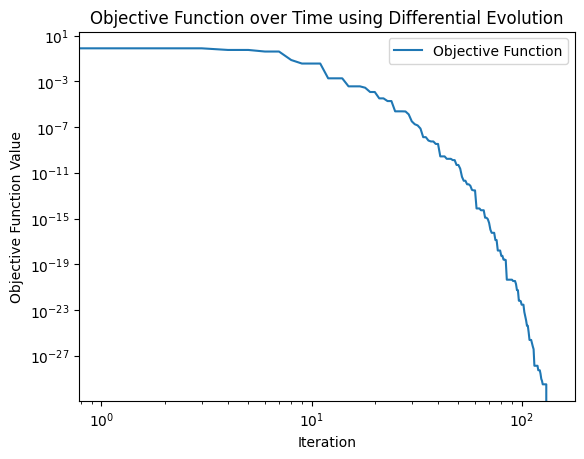

Optimized Solution: [5. 5. 5.]
Objective Function Value at Solution: 0.0


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Define the objective function
def objective_function(solution):
    return np.sum((solution - 5) ** 2)

# Callback function to track progress
history = []
def callback(x, convergence):
    history.append(objective_function(x))

# Bounds for the solution
bounds = [(-10, 10)] * 100  # Example with 3 variables, change as per your use case

# Run Differential Evolution
result = differential_evolution(objective_function, bounds, callback=callback)

# Plot the objective function over time (iterations)
plt.loglog(history, label="Objective Function")
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function over Time using Differential Evolution')
plt.legend()

plt.show()

# Print the result
print("Optimized Solution:", result.x)
print("Objective Function Value at Solution:", result.fun)


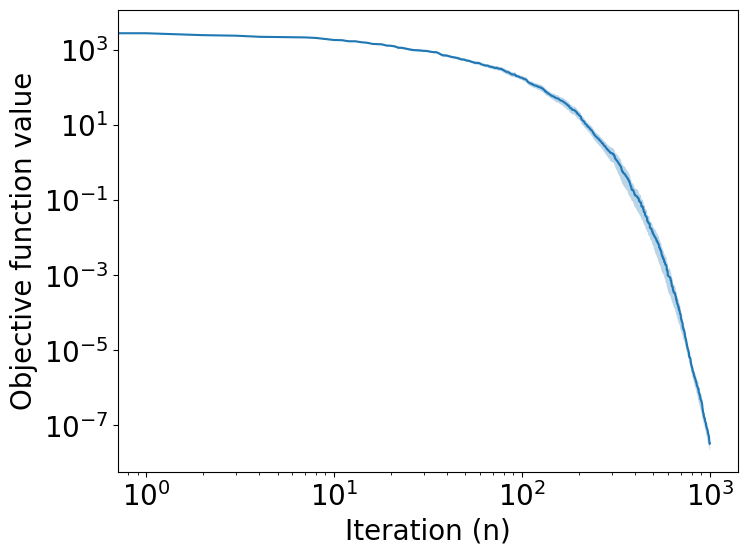

Optimized Solution (last run): [4.99999999 4.99999999 4.99999999 5.         4.99999999 4.99999999
 4.99999999 4.99999999 5.         5.         4.99999999 4.99999999
 5.         5.         5.         4.99999999 5.         4.99999999
 4.99999999 5.         5.         4.99999999 5.         4.99999999
 4.99999999 4.99999999 5.         4.99999999 5.         5.
 5.         4.99999999 4.99999999 5.         5.         4.99999999
 4.99999999 5.         4.99999999 4.99999999 5.         5.
 5.         4.99999999 4.99999999 4.99999999 5.         5.
 4.99999999 4.99999999 4.99999999 5.         4.99999999 5.
 4.99999999 5.         5.         4.99999999 5.         5.
 4.99999999 5.         5.         4.99999999 4.99999999 5.
 5.         5.         5.         5.         4.99999999 5.
 5.         5.         4.99999999 5.         5.         4.99999999
 4.99999999 5.         5.         4.99999999 4.99999999 4.99999999
 4.99999999 4.99999999 5.         4.99999999 4.99999999 4.99999999
 5.         5.      

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Define the objective function
def objective_function(solution):
    return np.sum((solution - 5) ** 2)

# Number of runs and iterations
num_runs = 10
max_iterations = 10000 # Set the maximum number of iterations (adjustable)

# Store the history of each run
all_histories = []

# Bounds for the solution
bounds = [(-10, 10)] * 100  # 100-dimensional problem

# Run DE multiple times and store history
for run in range(num_runs):
    history = []

    # Callback function to track progress for each run
    def callback(x, convergence):
        history.append(objective_function(x))

    # Run Differential Evolution for each run
    result = differential_evolution(objective_function, bounds, callback=callback)

    # Store the history (extend history to ensure uniform length)
    all_histories.append(np.array(history))

# Align the histories: padding shorter runs with the final value
max_len = max(len(h) for h in all_histories)
aligned_histories = np.array([np.pad(h, (0, max_len - len(h)), 'edge') for h in all_histories])

# Compute the average and standard deviation across runs
average_history = np.mean(aligned_histories, axis=0)
std_dev_history = np.std(aligned_histories, axis=0)

# Plot the average objective function over iterations
plt.figure(figsize=(8, 6))
plt.loglog(average_history, label="Average Objective Function")
plt.fill_between(range(max_len), average_history - std_dev_history/np.sqrt(num_runs), average_history + std_dev_history/np.sqrt(num_runs), alpha=0.3, label='±1 Std. Dev.')
   
plt.xlabel('Iteration (n)',fontsize=20)
plt.ylabel('Objective function value',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('Average Objective Function over Time (10 runs of Differential Evolution)')


plt.show()

# Print the final optimized solution and its value for one run (just as an example)
print("Optimized Solution (last run):", result.x)
print("Objective Function Value at Solution (last run):", result.fun)


In [3]:
plt.figure(figsize=(8, 6))
plt.loglog(average_history, label="Average Objective Function")
plt.fill_between(range(max_len), average_history - std_dev_history/np.sqrt(num_runs), average_history + std_dev_history/np.sqrt(num_runs), alpha=0.3, label='±1 Std. Dev.')
   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Average Objective Function over Time (10 runs of Differential Evolution)')
plt.legend()

plt.show()

# Print the final optimized solution and its value for one run (just as an example)
print("Optimized Solution (last run):", result.x)
print("Objective Function Value at Solution (last run):", result.fun)

NameError: name 'average_history' is not defined

<Figure size 800x600 with 0 Axes>

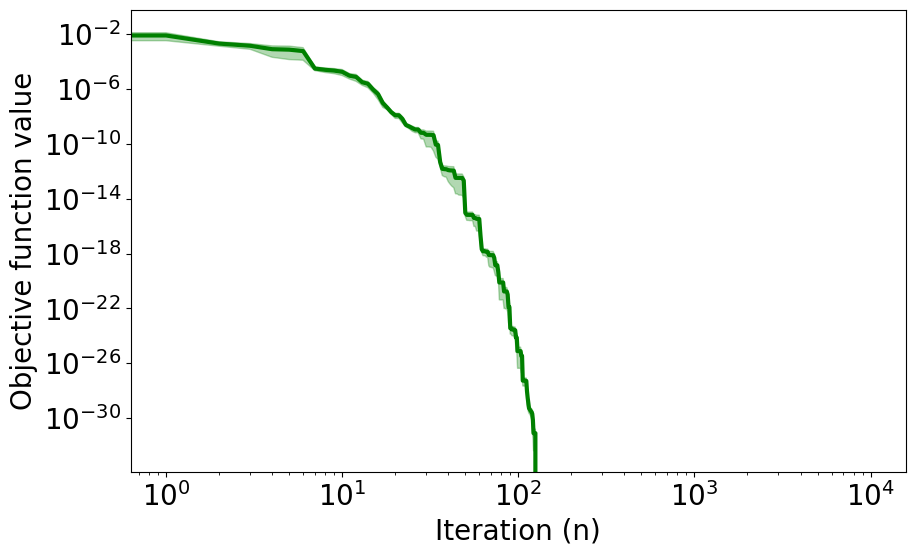

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the objective function (same as before)
def objective_function(solution):
    return np.sum((solution - 5) ** 2)

# Particle Swarm Optimization (PSO) implementation
def particle_swarm_optimization(objective_function, bounds, num_particles=50, max_iterations=10000, inertia=0.5, cognitive=1.5, social=1.5):
    num_dimensions = len(bounds)

    # Initialize particles' positions and velocities randomly within bounds
    particles_position = np.random.uniform(low=[b[0] for b in bounds], high=[b[1] for b in bounds], size=(num_particles, num_dimensions))
    particles_velocity = np.random.uniform(low=-10, high=10, size=(num_particles, num_dimensions))

    # Initialize personal best positions and global best position
    personal_best_positions = particles_position.copy()
    personal_best_scores = np.array([objective_function(p) for p in particles_position])
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # Track objective function value over iterations
    energy_history = []

    # Main loop of PSO
    for iteration in range(max_iterations):
        # Evaluate objective function for each particle
        scores = np.array([objective_function(p) for p in particles_position])

        # Update personal bests
        improved = scores < personal_best_scores
        personal_best_positions[improved] = particles_position[improved]
        personal_best_scores[improved] = scores[improved]

        # Update global best
        if np.min(personal_best_scores) < global_best_score:
            global_best_score = np.min(personal_best_scores)
            global_best_position = personal_best_positions[np.argmin(personal_best_scores)]

        # Update velocities and positions
        r1, r2 = np.random.rand(2)  # Random coefficients
        particles_velocity = (inertia * particles_velocity
                              + cognitive * r1 * (personal_best_positions - particles_position)
                              + social * r2 * (global_best_position - particles_position))
        particles_position = particles_position + particles_velocity

        # Store global best score (objective function value) for this iteration
        energy_history.append(global_best_score)

    return global_best_position, global_best_score, energy_history

# Number of simulations
num_simulations = 10

# Bounds for the solution (same as before)
bounds = [(-10, 10)]  # 100-dimensional problem

# Store energy histories
energy_histories_pso = []

# Run PSO multiple times
for _ in range(num_simulations):
    _, _, energy_history_pso = particle_swarm_optimization(objective_function, bounds)
    energy_histories_pso.append(energy_history_pso)

# Align the histories: padding shorter runs with the final value
max_len_pso = max(len(h) for h in energy_histories_pso)
aligned_histories_pso = np.array([np.pad(h, (0, max_len_pso - len(h)), 'edge') for h in energy_histories_pso])

# Compute the average energy history across simulations
average_energy_pso = np.mean(aligned_histories_pso, axis=0)
std_energy_pso = np.std(aligned_histories_pso, axis=0)
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Particle Swarm Optimization (PSO)
plt.loglog(average_energy_pso, label="Particle Swarm Optimization (PSO)",lw=3, color='green')
plt.fill_between(range(max_len_pso), average_energy_pso - std_energy_pso/np.sqrt(num_simulations), average_energy_pso + std_energy_pso/np.sqrt(num_simulations), alpha=0.3, color='green')
   
plt.xlabel('Iteration (n)',fontsize=20)
plt.ylabel('Objective function value',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()


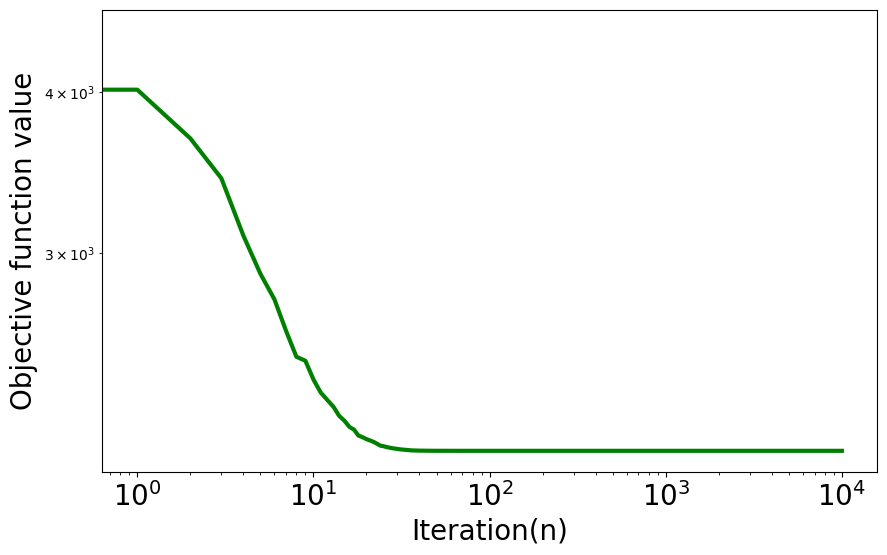

In [2]:
plt.figure(figsize=(10, 6))

# Plot Particle Swarm Optimization (PSO)
plt.loglog(average_energy_pso, label="Particle Swarm Optimization (PSO)",lw=3, color='green')

plt.xlabel('Iteration(n)',fontsize=20)
plt.ylabel('Objective function value',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()